Added Shape: horizontal_range -> HorizontalRange({'freq_min': 5261.529907119893, 'freq_max': 7229.450243714032, 'strength_dB': 9.291720192792653, 'sigma': 2.3187314203201117})
Added Shape: horizontal_line -> HorizontalLine({'center_freq': 5818.309928725323, 'strength_dB': 9.014762357880375, 'thickness': 3})
Added Shape: horizontal_line -> HorizontalLine({'center_freq': 3408.84535510307, 'strength_dB': 6.393194520500211, 'thickness': 1})
Added Shape: horizontal_range -> HorizontalRange({'freq_min': 1233.8370840557493, 'freq_max': 5744.157122755202, 'strength_dB': 5.902627415595277, 'sigma': 2.185066482260436})
Added Shape: horizontal_range -> HorizontalRange({'freq_min': 6087.415952503042, 'freq_max': 7256.608691902686, 'strength_dB': 7.661541573529179, 'sigma': 2.0254413411916627})
Added Shape: horizontal_range -> HorizontalRange({'freq_min': 7215.949619294449, 'freq_max': 7458.390844956418, 'strength_dB': 8.045310670997736, 'sigma': 2.8126477850141858})
Added Pattern: n_linear_repeat_

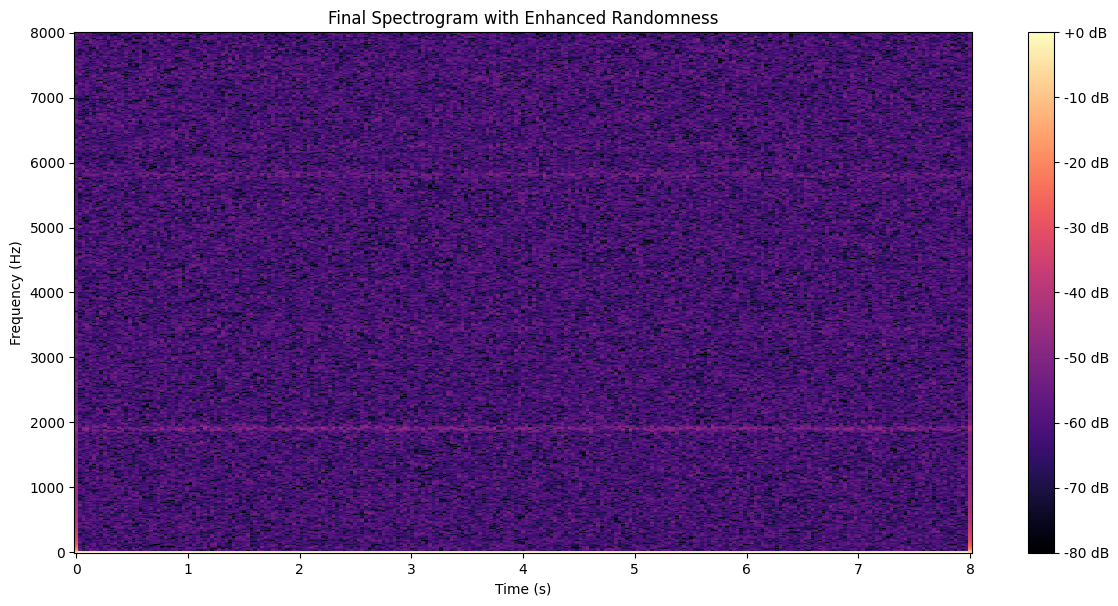

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod
from scipy.ndimage import gaussian_filter
from matplotlib.path import Path


# =========================================================
# 1) SpectrogramModifier
# =========================================================
class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=1024, hop_length=512,
                 noise_strength=0.1, noise_type='normal', noise_params=None):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def _generate_normal_noise(self, length, params):
        mean = params.get('mean', 0.0)
        std = params.get('std', 1.0)
        return np.random.normal(mean, std, length)

    def _generate_uniform_noise(self, length, params):
        low = params.get('low', -1.0)
        high = params.get('high', 1.0)
        return np.random.uniform(low, high, length)

    def _generate_perlin_noise(self, length, params):
        def fade(t):
            return 6 * t**5 - 15 * t**4 + 10 * t**3

        seed = params.get('seed', 42)
        np.random.seed(seed)
        perm = np.arange(256)
        np.random.shuffle(perm)
        perm = np.stack([perm, perm]).flatten()
        scale = params.get('scale', 50.0)
        xs = np.linspace(0, length / scale, length)
        xi = np.floor(xs).astype(int)
        xf = xs - xi
        xi = xi % 256
        left_hash = perm[xi]
        right_hash = perm[xi + 1]
        u = fade(xf)
        left_grad = ((left_hash & 1) * 2 - 1) * xf
        right_grad = ((right_hash & 1) * 2 - 1) * (xf - 1)
        noise = (1 - u) * left_grad + u * right_grad
        noise = noise / np.max(np.abs(noise))
        return noise

    def generate_noise(self, signal):
        length = len(signal)
        noise = np.zeros_like(signal)
        if self.noise_type == 'normal':
            noise = self._generate_normal_noise(length, self.noise_params)
        elif self.noise_type == 'uniform':
            noise = self._generate_uniform_noise(length, self.noise_params)
        elif self.noise_type == 'perlin':
            noise = self._generate_perlin_noise(length, self.noise_params)
        return signal + noise * self.noise_strength

    def compute_spectrogram(self, signal):
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(
            librosa.stft(
                self.signal_with_noise,
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                window='hann'
            )
        )
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        return librosa.frames_to_time(
            np.arange(self.S_db.shape[1]),
            sr=self.sample_rate,
            hop_length=self.hop_length
        )

    def apply_dB_mask(self, dB_mask):
        self.S_db += dB_mask

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        if self.S_db is None:
            raise ValueError("compute_spectrogram() must be called first.")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax


# =========================================================
# 2) DBShape (Abstract Base Class)
# =========================================================
class DBShape(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod):
        pass


# =========================================================
# 3) Shape Hierarchy
# =========================================================
class BaseShape(DBShape):
    def __init__(self):
        super().__init__()

    @abstractmethod
    def generate_shape_mask(self, spectro_shape, spectro_mod):
        pass

    def create_mask(self, spectro_shape, spectro_mod):
        return self.generate_shape_mask(spectro_shape, spectro_mod)

    def __repr__(self):
        return f"{self.__class__.__name__}({self.__dict__})"


# Circle Shape
class Circle(BaseShape):
    def __init__(self, center_freq, center_time, radius_freq, radius_time, strength_dB):
        super().__init__()
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = (
            ((ff - self.center_freq) / self.radius_freq) ** 2 +
            ((tt - self.center_time) / self.radius_time) ** 2
        )
        mask = (dist <= 1).astype(float) * self.strength_dB
        return mask


# Spike Shape
class Spike(BaseShape):
    def __init__(self, center_freq, center_time, length_freq, length_time, strength_dB, angle_deg=0.0):
        super().__init__()
        self.center_freq = center_freq
        self.center_time = center_time
        self.length_freq = length_freq
        self.length_time = length_time
        self.strength_dB = strength_dB
        self.angle_deg = angle_deg

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        # Shift to center
        f_shift = ff - self.center_freq
        t_shift = tt - self.center_time

        # Rotate
        angle_rad = np.deg2rad(self.angle_deg)
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)
        f_rot = f_shift * cos_a - t_shift * sin_a
        t_rot = f_shift * sin_a + t_shift * cos_a

        # Create spike
        dist = np.sqrt((f_rot / self.length_freq) ** 2 + (t_rot / self.length_time) ** 2)
        mask = np.exp(-dist * 5) * self.strength_dB
        return mask


# Rectangle Shape
class Rectangle(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max, strength_dB):
        super().__init__()
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if not freq_indices.size or not time_indices.size:
            return mask
        mask[np.ix_(freq_indices, time_indices)] = self.strength_dB
        return mask


# Ellipse Shape
class Ellipse(BaseShape):
    def __init__(self, center_freq, center_time, radius_freq, radius_time, strength_dB):
        super().__init__()
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = (
            ((ff - self.center_freq) / self.radius_freq) ** 2 +
            ((tt - self.center_time) / self.radius_time) ** 2
        )
        mask = (dist <= 1).astype(float) * self.strength_dB
        return mask


# Fog Shape
class Fog(BaseShape):
    def __init__(self, strength_dB, coverage=1.0):
        super().__init__()
        self.strength_dB = strength_dB
        self.coverage = coverage

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        random_map = np.random.uniform(0, 1, spectro_shape)
        fog = (random_map < self.coverage).astype(float)
        fog *= self.strength_dB * (np.random.randn(*spectro_shape) * 0.1)
        return fog


# Horizontal Line Shape
class HorizontalRange(BaseShape):
    def __init__(self, freq_min, freq_max, strength_dB, sigma=10.0):
        super().__init__()
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB
        self.sigma = sigma

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        mask = np.zeros(spectro_shape)

        # 주파수 범위 내의 인덱스 찾기
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if not freq_indices.size:
            return mask

        freq_values = freqs[freq_indices]
        center = (self.freq_min + self.freq_max) / 2
        distribution = np.exp(-0.5 * ((freq_values - center) / self.sigma) ** 2)
        distribution /= distribution.max()

        # 벡터화된 연산으로 마스크 생성
        mask[freq_indices, :] += self.strength_dB * distribution[:, np.newaxis]

        return mask


# Vertical Line Shape
class VerticalLine(BaseShape):
    def __init__(self, center_time, strength_dB, thickness=1):
        super().__init__()
        self.center_time = center_time
        self.strength_dB = strength_dB
        self.thickness = thickness

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_idx = np.argmin(np.abs(times - self.center_time))
        start_idx = max(time_idx - self.thickness // 2, 0)
        end_idx = min(time_idx + self.thickness // 2 + 1, spectro_shape[1])
        mask[:, start_idx:end_idx] = self.strength_dB
        return mask


# Horizontal Range Shape with Gaussian Distribution
class HorizontalRange(BaseShape):
    def __init__(self, freq_min, freq_max, strength_dB, sigma=1.0):
        super().__init__()
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB
        self.sigma = sigma

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if not freq_indices.size:
            return mask
        freq_values = freqs[freq_indices]
        center = (self.freq_min + self.freq_max) / 2
        distribution = np.exp(-0.5 * ((freq_values - center) / self.sigma) ** 2)
        distribution /= distribution.max()
        for i, fi in enumerate(freq_indices):
            mask[fi, :] += self.strength_dB * distribution[i]
        return mask


# Vertical Range Shape with Gaussian Distribution
class VerticalRange(BaseShape):
    def __init__(self, time_min, time_max, strength_dB, sigma=0.5):
        super().__init__()
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB
        self.sigma = sigma

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if not time_indices.size:
            return mask
        time_vals = times[time_indices]
        center = (self.time_min + self.time_max) / 2
        distribution = np.exp(-0.5 * ((time_vals - center) / self.sigma) ** 2)
        distribution /= distribution.max()
        for i, ti in enumerate(time_indices):
            mask[:, ti] += self.strength_dB * distribution[i]
        return mask


# Hill Shape
class Hill(BaseShape):
    def __init__(self, freq_center, time_center, freq_width, time_width, strength_dB):
        super().__init__()
        self.freq_center = freq_center
        self.time_center = time_center
        self.freq_width = freq_width
        self.time_width = time_width
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = np.sqrt(
            ((ff - self.freq_center) / self.freq_width) ** 2 +
            ((tt - self.time_center) / self.time_width) ** 2
        )
        hill = (1 - dist)
        hill[hill < 0] = 0
        mask = hill * self.strength_dB
        return mask


# Wave Pattern Shape
class WavePattern(BaseShape):
    def __init__(self, axis='time', frequency=1.0, strength_dB=5.0):
        super().__init__()
        self.axis = axis
        self.frequency = frequency
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        mask = np.zeros(spectro_shape)
        if self.axis == 'time':
            wave = np.sin(2 * np.pi * self.frequency * times)
            mask += wave[np.newaxis, :] * self.strength_dB
        else:
            wave = np.sin(2 * np.pi * self.frequency * freqs)
            mask += wave[:, np.newaxis] * self.strength_dB
        return mask


# Polygon Shape
class Polygon(BaseShape):
    def __init__(self, vertices, strength_dB):
        super().__init__()
        self.vertices = vertices
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        path = Path(self.vertices)
        points = np.vstack((ff.ravel(), tt.ravel())).T
        inside = path.contains_points(points).reshape(ff.shape)
        mask = np.zeros(spectro_shape)
        mask[inside] = self.strength_dB
        return mask


# =========================================================
# 4) Pattern Hierarchy
# =========================================================
class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        pass

    def __repr__(self):
        return f"{self.__class__.__name__}({self.__dict__})"


# Linear Pattern
class LinearPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 direction='time', repeat=5, spacing=1.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.direction = direction
        self.repeat = repeat
        self.spacing = spacing

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        mask = np.zeros(spectro_shape)
        for i in range(self.repeat):
            offset = i * self.spacing
            params = self.shape_params.copy()
            if self.direction == 'time' and 'center_time' in params:
                params['center_time'] += offset
            elif self.direction == 'freq' and 'center_freq' in params:
                params['center_freq'] += offset

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


# Random Pattern
class RandomPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 n=10, freq_range=None, time_range=None):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.n = n
        self.freq_range = freq_range if freq_range else (0, 8000)
        self.time_range = time_range if time_range else (0, 10)

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        mask = np.zeros(spectro_shape)
        for _ in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = np.random.uniform(*self.freq_range)
            if 'center_time' in params:
                params['center_time'] = np.random.uniform(*self.time_range)

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


# N Linear Repeat with Sleep Pattern
class NLinearRepeatSleepPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 repeat=3, repeat_time=0.5,
                 sleep_time=5.0, start_time=0.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.repeat = repeat
        self.repeat_time = repeat_time
        self.sleep_time = sleep_time
        self.start_time = start_time

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        mask = np.zeros(spectro_shape)
        current_time = self.start_time
        for _ in range(self.repeat):
            params = self.shape_params.copy()
            if 'center_time' in params:
                params['center_time'] = current_time

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
            current_time += self.repeat_time

        current_time += self.sleep_time
        return mask


# Convex Pattern
class ConvexPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 freq_min, freq_max, time_min, time_max,
                 n=10):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.n = n

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        mask = np.zeros(spectro_shape)
        freqs = np.linspace(self.freq_min, self.freq_max, self.n)
        times = np.linspace(self.time_min, self.time_max, self.n)
        for i in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = freqs[i]
            if 'center_time' in params:
                params['center_time'] = times[i]

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


# Function Pattern
class FunctionPattern(Pattern):
    def __init__(self, func):
        self.func = func

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        return self.func(ff, tt)


# =========================================================
# 5) Factory Classes
# =========================================================
class ShapeFactory:
    def create(self, shape_name, **kwargs):
        shape_name = shape_name.lower()
        try:
            if shape_name == "circle":
                return Circle(**kwargs)
            elif shape_name == "rectangle":
                return Rectangle(**kwargs)
            elif shape_name == "ellipse":
                return Ellipse(**kwargs)
            elif shape_name == "spike":
                return Spike(**kwargs)
            elif shape_name == "fog":
                return Fog(**kwargs)
            elif shape_name == "horizontal_line":
                return HorizontalLine(**kwargs)
            elif shape_name == "vertical_line":
                return VerticalLine(**kwargs)
            elif shape_name == "horizontal_range":
                return HorizontalRange(**kwargs)
            elif shape_name == "vertical_range":
                return VerticalRange(**kwargs)
            elif shape_name == "hill":
                return Hill(**kwargs)
            elif shape_name == "wave_pattern":
                return WavePattern(**kwargs)
            elif shape_name == "polygon":
                return Polygon(**kwargs)
            else:
                raise ValueError(f"Unknown shape name: {shape_name}")
        except KeyError as e:
            raise ValueError(f"Missing parameter {e} for shape {shape_name}")


class PatternFactory:
    def create(self, pattern_name, params):
        pattern_name = pattern_name.lower()
        if pattern_name == "linear":
            return LinearPattern(**params)
        elif pattern_name == "random":
            return RandomPattern(**params)
        elif pattern_name == "n_linear_repeat_sleep":
            return NLinearRepeatSleepPattern(**params)
        elif pattern_name == "convex":
            return ConvexPattern(**params)
        elif pattern_name == "function":
            return FunctionPattern(**params)
        else:
            raise ValueError(f"Unknown pattern name: {pattern_name}")


# =========================================================
# 6) NoisePipeline (Updated with return_masks)
# =========================================================
class NoisePipeline:
    def __init__(self, spectro_mod, apply_blur=False, blur_sigma=1.0):
        self.spectro_mod = spectro_mod
        self.shape_factory = ShapeFactory()
        self.pattern_factory = PatternFactory()
        self.shapes = []
        self.patterns = []
        self.apply_blur = apply_blur
        self.blur_sigma = blur_sigma

    def add_shape(self, shape):
        self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        if pattern is not None:
            self.patterns.append(pattern)
        return self

    def generate(self, signal, return_masks=False):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)
        masks = []

        # Apply Shapes
        for shape in self.shapes:
            mask = shape.create_mask(spec.shape, self.spectro_mod)  # 올바른 변수 사용
            total_mask += mask
            masks.append((shape.__class__.__name__, mask))

        # Apply Patterns
        for pattern in self.patterns:
            mask = pattern.create_mask(spec.shape, self.spectro_mod, self.shape_factory)  # 올바른 변수 사용
            total_mask += mask
            masks.append((pattern.__class__.__name__, mask))

        # Apply Blur if enabled
        if self.apply_blur and self.blur_sigma > 0:
            total_mask = gaussian_filter(total_mask, sigma=self.blur_sigma)

        # Apply the total mask to the spectrogram
        self.spectro_mod.apply_dB_mask(total_mask)

        if return_masks:
            return self.spectro_mod.S_db, masks
        return self.spectro_mod.S_db




# =========================================================
# 7) Weighted Random Selection Function
# =========================================================
def pick_item_from_ratio(ratio_dict):
    items = list(ratio_dict.keys())
    weights = list(ratio_dict.values())
    total = sum(weights)
    r = random.uniform(0, total)
    s = 0
    for item, w in zip(items, weights):
        s += w
        if r <= s:
            return item
    return items[-1]


# =========================================================
# 8) Generate Shape Parameters with Constraints
# =========================================================
def generate_shape_params(shape_name, duration, sr,
                          freq_min=20, time_min=0.0,
                          min_float_value=0.001, alpha=1.0, max_db_power=10):
    params = {
        "strength_dB": random.uniform(5, max_db_power)
    }

    random_freq_min = random.uniform(freq_min, sr)
    random_freq_max = random.uniform(freq_min, sr)
    if random_freq_min > random_freq_max:
        random_freq_min, random_freq_max = random_freq_max, random_freq_min

    random_time_min = random.uniform(time_min, duration)
    random_time_max = random.uniform(time_min, duration)
    if random_time_min > random_time_max:
        random_time_min, random_time_max = random_time_max, random_time_min


    # Define specific ranges for each shape to ensure uniqueness
    if shape_name == "spike":
        params.update({
            "center_freq": random.uniform(random_freq_min, random_freq_max),
            "center_time": random.uniform(random_time_min, random_time_max),
            "length_freq": random.uniform(10, 100),
            "length_time": random.uniform(0.1, 2.0),
            "angle_deg": random.uniform(-45, 45)
        })
    elif shape_name == "circle":
        params.update({
            "center_freq": random.uniform(freq_min, sr * alpha / 2),
            "center_time": random.uniform(time_min, duration * alpha / 2),
            "radius_freq": random.uniform(5, 50),
            "radius_time": random.uniform(5, 50)
        })
    elif shape_name == "rectangle":
        freq_range = sr * alpha / 2
        time_range = duration * alpha / 2
        f_min = random.uniform(freq_min, freq_range - 50)
        f_max = random.uniform(f_min + 10, freq_range)
        t_min = random.uniform(time_min, time_range - 1)
        t_max = random.uniform(t_min + 0.5, time_range)
        params.update({
            "freq_min": f_min,
            "freq_max": f_max,
            "time_min": t_min,
            "time_max": t_max
        })
    elif shape_name == "ellipse":
        params.update({
            "center_freq": random.uniform(freq_min, sr * alpha / 2),
            "center_time": random.uniform(time_min, duration * alpha / 2),
            "radius_freq": random.uniform(5, 50),
            "radius_time": random.uniform(5, 50)
        })
    elif shape_name == "fog":
        params.update({
            "coverage": random.uniform(0.1, 0.5)  # Avoid complete coverage
        })
    elif shape_name == "horizontal_line":
        params.update({
            "center_freq": random.uniform(0, sr * alpha / 2),
            "thickness": random.randint(1, 3)
        })
    elif shape_name == "vertical_line":
        params.update({
            "center_time": random.uniform(time_min, duration * alpha / 2),
            "thickness": random.randint(1, 3)
        })
    elif shape_name == "horizontal_range":
        f_min = random.uniform(freq_min, sr * alpha / 2 - 50)
        f_max = random.uniform(f_min + 10, sr * alpha / 2)
        params.update({
            "freq_min": f_min,
            "freq_max": f_max,
            "sigma": random.uniform(1.0, 3.0)
        })
    elif shape_name == "vertical_range":
        t_min = random.uniform(time_min, duration * alpha / 2 - 1)
        t_max = random.uniform(t_min + 0.5, duration * alpha / 2)
        params.update({
            "time_min": t_min,
            "time_max": t_max,
            "sigma": random.uniform(0.5, 1.5)
        })
    elif shape_name == "hill":
        params.update({
            "freq_center": random.uniform(freq_min, sr * alpha / 2),
            "time_center": random.uniform(time_min, duration * alpha / 2),
            "freq_width": random.uniform(10, 50),
            "time_width": random.uniform(10, 50)
        })
    elif shape_name == "wave_pattern":
        params.update({
            "axis": random.choice(["time", "freq"]),
            "frequency": random.uniform(0.1, 5.0)
        })
    elif shape_name == "polygon":
        num_vertices = random.randint(3, 6)
        vertices = []
        for _ in range(num_vertices):
            f_rand = random.uniform(freq_min, sr * alpha / 2)
            t_rand = random.uniform(time_min, duration * alpha / 2)
            vertices.append([f_rand, t_rand])
        params.update({
            "vertices": vertices
        })
    else:
        # Default to circle parameters if unknown shape
        params.update({
            "center_freq": random.uniform(freq_min, sr * alpha / 2),
            "center_time": random.uniform(time_min, duration * alpha / 2),
            "radius_freq": random.uniform(5, 50),
            "radius_time": random.uniform(5, 50)
        })

    return params


def create_random_noise_pipeline(
    spectro_mod,
    max_shapes=5,
    max_patterns=3,
    apply_blur=False,
    blur_sigma=2.0,
    duration=8.0,
    sr=16000,
    freq_min=20,
    min_float_value=0.001,
    alpha=1.0,
    ratio_shape=None,
    ratio_pattern=None,
    max_db_power=10
):
    """
    ratio_shape, ratio_pattern examples:
    ratio_shape = {"circle": 1, "rectangle": 2, "ellipse": 3, ...}
    ratio_pattern = {"linear": 1, "random": 2, "convex": 1, ...}
    """
    pipeline = NoisePipeline(spectro_mod, apply_blur=apply_blur, blur_sigma=blur_sigma)

    # Define default shapes and patterns
    default_shapes = [
        "circle", "rectangle", "ellipse", "spike", "fog",
        "horizontal_line", "vertical_line",
        "horizontal_range", "vertical_range",
        "hill", "wave_pattern", "polygon"
    ]
    default_patterns = [
        "linear", "random", "n_linear_repeat_sleep", "convex"
    ]

    if ratio_shape is None:
        ratio_shape = {s: 1 for s in default_shapes}
    if ratio_pattern is None:
        ratio_pattern = {p: 1 for p in default_patterns}

    shape_factory = pipeline.shape_factory
    pattern_factory = pipeline.pattern_factory

    # 1) Add Shapes
    for _ in range(random.randint(1, max_shapes)):
        shape_name = pick_item_from_ratio(ratio_shape)
        try:
            shape_params = generate_shape_params(
                shape_name=shape_name,
                duration=duration,
                sr=sr,
                freq_min=freq_min,
                time_min=0.0,
                min_float_value=min_float_value,
                alpha=alpha,
                max_db_power=max_db_power
            )
            shape = shape_factory.create(shape_name, **shape_params)
            pipeline.add_shape(shape)
            print(f"Added Shape: {shape_name} -> {shape}")
        except Exception as e:
            print(f"Error creating shape '{shape_name}': {e}.")

    # 2) Add Patterns
    if max_patterns > 0:
        for _ in range(random.randint(1, max_patterns)):
            pattern_name = pick_item_from_ratio(ratio_pattern)
            try:
                shape_name = pick_item_from_ratio(ratio_shape)
                shape_params = generate_shape_params(
                    shape_name=shape_name,
                    duration=duration,
                    sr=sr,
                    freq_min=freq_min,
                    time_min=0.0,
                    min_float_value=min_float_value,
                    alpha=alpha,
                    max_db_power=max_db_power
                )
                pattern_kwargs = {
                    "shape_name": shape_name,
                    "shape_params": shape_params
                }

                # Additional parameters based on pattern type
                if pattern_name == "linear":
                    pattern_kwargs.update({
                        "direction": random.choice(["time", "freq"]),
                        "repeat": random.randint(2, 5),
                        "spacing": random.uniform(0.5, 2.0)
                    })
                elif pattern_name == "random":
                    pattern_kwargs.update({
                        "n": random.randint(3, 10),
                        "freq_range": (freq_min, sr * alpha / 2),
                        "time_range": (0.0, duration * alpha / 2)
                    })
                elif pattern_name == "n_linear_repeat_sleep":
                    pattern_kwargs.update({
                        "repeat": random.randint(2, 5),
                        "repeat_time": random.uniform(0.5, 2.0),
                        "sleep_time": random.uniform(1.0, 5.0),
                        "start_time": random.uniform(0.0, duration * alpha / 2)
                    })
                elif pattern_name == "convex":
                    pattern_kwargs.update({
                        "freq_min": random.uniform(freq_min, sr * alpha / 2 - 50),
                        "freq_max": random.uniform(freq_min + 50, sr * alpha / 2),
                        "time_min": random.uniform(0.0, duration * alpha / 2 - 1.0),
                        "time_max": random.uniform(1.0, duration * alpha / 2),
                        "n": random.randint(3, 6)
                    })

                pattern = pattern_factory.create(pattern_name, pattern_kwargs)
                pipeline.add_pattern(pattern)
                print(f"Added Pattern: {pattern_name} -> {pattern}")
            except Exception as e:
                print(f"Error creating pattern '{pattern_name}': {e}.")

    return pipeline




# =========================================================
# 10) Spectrogram to Audio Reconstruction
# =========================================================
def reconstruct_with_griffinlim(spectrogram_db, n_iter=32, hop_length=512):
    amplitude = librosa.db_to_amplitude(spectrogram_db, ref=1.0)
    new_audio = librosa.griffinlim(
        amplitude,
        n_iter=n_iter,
        hop_length=hop_length,
        window='hann'
    )
    return new_audio


def reconstruct_audio_from_final_spectrogram(spectro_mod, hop_length=512):
    stft_orig = librosa.stft(
        spectro_mod.signal_with_noise,
        n_fft=spectro_mod.n_fft,
        hop_length=spectro_mod.hop_length,
        window='hann'
    )
    phase = np.angle(stft_orig)
    magnitude = librosa.db_to_amplitude(spectro_mod.S_db, ref=1.0)
    new_stft = magnitude * np.exp(1j * phase)
    new_audio = librosa.istft(
        new_stft,
        hop_length=hop_length,
        window='hann'
    )
    return new_audio


# =========================================================
# 11) Example Usage
# =========================================================
if __name__ == "__main__":
    sr = 16000
    duration = 8.0
    total_strength = np.random.uniform(-80, 0)
    n_samples = int(sr * duration)
    signal = np.random.normal(total_strength, 1, n_samples)

    spectro_mod = SpectrogramModifier(
        sample_rate=sr,
        n_fft=1024,
        hop_length=512,
        noise_strength=1.0,
        noise_type='normal',
        noise_params={'mean': 0.0, 'std': 1.0}
    )

    # Define shape and pattern ratios
    ratio_shape = {
        "circle": 0,
        "rectangle": 0,
        "ellipse": 1,    # Must remain ellipse, not circle
        "spike": 1,      # Must remain spike
        "fog": 1,        # Requires precise criteria
        "horizontal_line": 10,
        "vertical_line": 1,
        "horizontal_range": 10,  # Renamed from horizontal_range_dist_db
        "vertical_range": 1,    # Renamed from vertical_range_dist_db
        "hill": 1,              # Must appear as hill
        "wave_pattern": 1,      # Adjusted for sine-like patterns
        "polygon": 1            # Must not resemble rectangle
    }

    ratio_pattern = {
        "linear": 1,
        "random": 1,
        "n_linear_repeat_sleep": 1
    }

    pipeline = create_random_noise_pipeline(
        spectro_mod,
        max_shapes=10,
        max_patterns=2,
        apply_blur=True,
        blur_sigma=2.0,
        duration=duration,
        sr=sr,
        freq_min=0,
        min_float_value=0.001,
        alpha=1.0,
        ratio_shape=ratio_shape,
        ratio_pattern=ratio_pattern,
        max_db_power=10
    )

    result_db = pipeline.generate(signal)
    print("NoisePipeline applied successfully.")

    spectro_mod.plot_spectrogram(title='Final Spectrogram with Enhanced Randomness')
    plt.show()

    reconstructed_audio = reconstruct_audio_from_final_spectrogram(spectro_mod, hop_length=512)

    # Play audio (only works in environments like Jupyter Notebook)
    try:
        import IPython.display as ipd
        audio_widget = ipd.Audio(data=reconstructed_audio, rate=sr)
        display(audio_widget)
    except ImportError:
        print("IPython is not available. Cannot display audio widget.")


Added Shape: horizontal_range -> HorizontalRange({'freq_min': 23809.802633603034, 'freq_max': 47319.26000276783, 'strength_dB': 8.31016875882343, 'sigma': 1.6918746583483084})
NoisePipeline applied successfully.


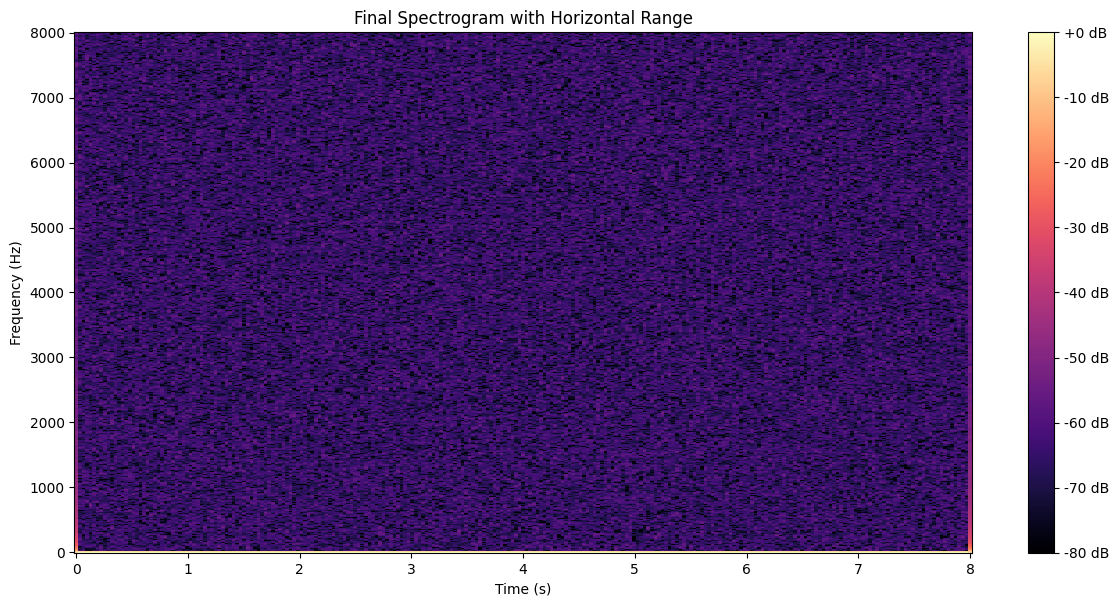

HorizontalRange Mask - Max: 0.0, Min: 0.0


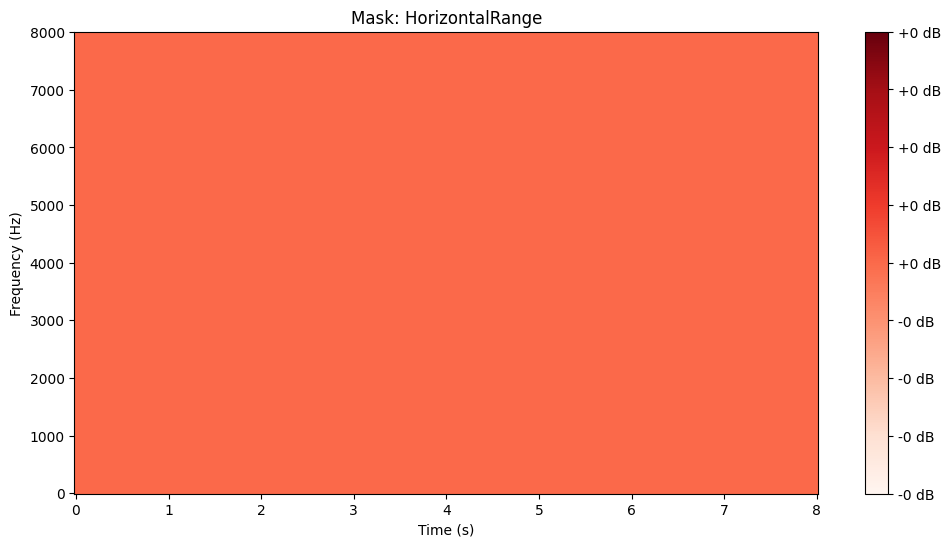

In [343]:
# =========================================================
# 11) Example Usage with Fix Applied
# =========================================================
if __name__ == "__main__":
    sr = 16000
    duration = 8.0
    n_samples = int(sr * duration)
    signal = np.random.normal(-80, 1, n_samples)

    spectro_mod = SpectrogramModifier(
        sample_rate=sr,
        n_fft=1024,
        hop_length=512,
        noise_strength=1.0,
        noise_type='normal',
        noise_params={'mean': 0.0, 'std': 1.0}
    )

    # Define shape and pattern ratios with only horizontal_range
    ratio_shape = {
        "horizontal_range": 1
    }

    # Define pattern ratios with none or minimal patterns
    ratio_pattern = {
        # "linear": 0,  # Comment out or set to 0 to exclude
        # "random": 0,
        # "n_linear_repeat_sleep": 0
    }

    pipeline = create_random_noise_pipeline(
        spectro_mod,
        max_shapes=1,      # Only add one shape
        max_patterns=0,    # No patterns
        apply_blur=True,
        blur_sigma=2.0,
        duration=duration,
        sr=sr,
        freq_min=0,
        min_float_value=0.001,
        alpha=10.0,
        ratio_shape=ratio_shape,
        ratio_pattern=ratio_pattern,
        max_db_power=15    # Increased max_db_power for visibility
    )

    # Generate spectrogram and retrieve masks
    result_db, masks = pipeline.generate(signal, return_masks=True)
    print("NoisePipeline applied successfully.")

    # Plot the final spectrogram
    spectro_mod.plot_spectrogram(title='Final Spectrogram with Horizontal Range')
    plt.show()

    # Plot individual masks
    for name, mask in masks:
        if name == "HorizontalRange":
            print(f"{name} Mask - Max: {mask.max()}, Min: {mask.min()}")
            fig, ax = plt.subplots(figsize=(12, 6))
            img = librosa.display.specshow(
                mask,
                sr=spectro_mod.sample_rate,
                hop_length=spectro_mod.hop_length,
                x_axis='time',
                y_axis='linear',
                ax=ax,
                cmap='Reds'
            )
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(f'Mask: {name}')
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
            plt.show()

    # Optionally, reconstruct and play audio
    reconstructed_audio = reconstruct_audio_from_final_spectrogram(spectro_mod, hop_length=512)

    # Play audio (only works in environments like Jupyter Notebook)
    try:
        import IPython.display as ipd
        audio_widget = ipd.Audio(data=reconstructed_audio, rate=sr)
        display(audio_widget)
    except ImportError:
        print("IPython is not available. Cannot display audio widget.")


In [226]:
ratio_pattern = {
    "cicrle": 1,
    ...
}

pipeline = create_random_noise_pipeline(
        spectro_mod,
        max_shapes=3,
        max_patterns=10,
        apply_blur=True,
        blur_sigma=2.0,
        duration=duration,
        sr=sr,
        freq_min=0,
        min_float_value=0.0,
        ratio_pattern=ratio_pattern,
        ratio_shape=ratio_shape,
    )

SyntaxError: invalid syntax (3113713789.py, line 4)